In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Importing libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf


# 1. linear regression

In [2]:
rentals = pd.read_csv("../data/cleaned_data/rentals_processed.csv")

In [3]:
rentals = rentals[pd.to_numeric(rentals['postal'], errors='coerce').notna()]
rentals['postal'] = rentals['postal'].astype(int)

# Convert approval month
rentals['month_approved'] = pd.to_datetime(rentals['rent_approval_date']).dt.month
label_encoder = LabelEncoder()
rentals['month_approved'] = label_encoder.fit_transform(rentals['month_approved'])
rentals['flat_type'] = label_encoder.fit_transform(rentals['flat_type'])
rentals.head()

# get the flat_type: encoding mapping

# get the categories for the 'flat_type' feature
print(label_encoder.classes_)
# create a mapping of flat_type names to their encodings
flat_type_categories = label_encoder.classes_
flat_type_to_encoding = {flat_type: i for i, flat_type in enumerate(flat_type_categories)}
print(flat_type_to_encoding)

['1-ROOM' '2-ROOM' '3-ROOM' '4-ROOM' '5-ROOM' 'EXECUTIVE']
{'1-ROOM': 0, '2-ROOM': 1, '3-ROOM': 2, '4-ROOM': 3, '5-ROOM': 4, 'EXECUTIVE': 5}


In [4]:
rentals.sample()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,lat,lng,building,postal,...,supermarket_dist,nearest_amenity,amenity_dist,nearest_school,school_dist,year_approved,max_floor_lvl,nearest_park_dist,nearest_park,month_approved
5608,2021-02-01,TOA PAYOH,145,LORONG 2 TOA PAYOH,3,1420,1.33521,103.846163,TOA PAYOH TOWERS,310145,...,0.279263,500 LORONG 6 TOA PAYOH,0.279263,Kheng Cheng School,0.255433,2021,40.0,0.553555,TOA PAYOH TOWN PK,1


In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(rentals[['lat', 'lng']])
rentals['location_cluster'] = kmeans.labels_

/Users/seaheewei/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
rentals.columns

Index(['rent_approval_date', 'town', 'block', 'street_name', 'flat_type',
       'monthly_rent', 'lat', 'lng', 'building', 'postal', 'nearest_station',
       'station_dist', 'nearest_mall', 'mall_dist', 'nearest_hawker',
       'hawker_dist', 'nearest_supermarket', 'supermarket_dist',
       'nearest_amenity', 'amenity_dist', 'nearest_school', 'school_dist',
       'year_approved', 'max_floor_lvl', 'nearest_park_dist', 'nearest_park',
       'month_approved', 'location_cluster'],
      dtype='object')

In [7]:
rentals = rentals.drop(['block', 'street_name', 'building', 'nearest_hawker', 'lng','rent_approval_date','nearest_school', 'nearest_mall', 'nearest_supermarket','nearest_amenity','nearest_park','supermarket_dist', 'amenity_dist', 'hawker_dist'], axis=1)

In [8]:
rentals.columns

Index(['town', 'flat_type', 'monthly_rent', 'lat', 'postal', 'nearest_station',
       'station_dist', 'mall_dist', 'school_dist', 'year_approved',
       'max_floor_lvl', 'nearest_park_dist', 'month_approved',
       'location_cluster'],
      dtype='object')

In [9]:
selected_features = [
'town',
'flat_type',
'monthly_rent',
'lat',
'postal',
'nearest_station',
'station_dist',
'mall_dist',
'school_dist',
'year_approved',
'max_floor_lvl',
'nearest_park_dist',
'month_approved',
'location_cluster'
]

numeric_features = [
'flat_type',
'monthly_rent',
'lat',
'postal',
'station_dist',
'mall_dist',
'school_dist',
'year_approved',
'max_floor_lvl',
'nearest_park_dist',
'month_approved',
'location_cluster'
 ]

# will only use the numeric features that have been selected earlier on
numeric_x_features = [name for name in numeric_features if name in selected_features and name != 'monthly_rent']
numeric_x_features


['flat_type',
 'lat',
 'postal',
 'station_dist',
 'mall_dist',
 'school_dist',
 'year_approved',
 'max_floor_lvl',
 'nearest_park_dist',
 'month_approved',
 'location_cluster']

In [10]:
# set the polynomial. 3 means "I want to include up to and including x^3". personally i think 3 is the max
polynomial = 3

# craft a formula with polynomial features
all_features = [name for name in selected_features if name != 'monthly_rent']

if polynomial > 1:
    for power in range(2, polynomial + 1):
        for name in numeric_x_features:
            all_features.append(f'I({name}**{power})')

print('Training features are: ', all_features)

Training features are:  ['town', 'flat_type', 'lat', 'postal', 'nearest_station', 'station_dist', 'mall_dist', 'school_dist', 'year_approved', 'max_floor_lvl', 'nearest_park_dist', 'month_approved', 'location_cluster', 'I(flat_type**2)', 'I(lat**2)', 'I(postal**2)', 'I(station_dist**2)', 'I(mall_dist**2)', 'I(school_dist**2)', 'I(year_approved**2)', 'I(max_floor_lvl**2)', 'I(nearest_park_dist**2)', 'I(month_approved**2)', 'I(location_cluster**2)', 'I(flat_type**3)', 'I(lat**3)', 'I(postal**3)', 'I(station_dist**3)', 'I(mall_dist**3)', 'I(school_dist**3)', 'I(year_approved**3)', 'I(max_floor_lvl**3)', 'I(nearest_park_dist**3)', 'I(month_approved**3)', 'I(location_cluster**3)']


In [11]:
# Splitting the data into training and testing sets.
rentals = rentals[selected_features]
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train, test = train_test_split(rentals, test_size=0.2, random_state=42)

# Separate features and target variable
X_train, X_test = train.drop('monthly_rent', axis=1), test.drop('monthly_rent', axis=1)
y_train, y_test = train['monthly_rent'], test['monthly_rent']

In [12]:
rental_regression = smf.ols(formula=f'monthly_rent ~ {" + ".join(all_features)}', data=train).fit()
rental_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           monthly_rent   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 1.234e+04
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:03:56   Log-Likelihood:            -6.7715e+05
No. Observations:               87110   AIC:                         1.354e+06
Df Residuals:                   87105   BIC:                         1.354e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                -3.155e-06   1.65e-08   -190.709      0.000   -3.19e-06   -3.12e-06
town[T.BEDOK]                                               -0.0028   5.85e-05    -47.304      0.000      -0.003      -0.003
town[T.BISHAN]                                           -2.333e-07   4.48e-09    -52.136      0.000   -2.42e-07   -2.25e-07
town[T.BUKIT BATOK]                                      -5.157e-07   1.33e-08    -38.800      0.000   -5.42e-07    -4.9e-07
town[T.BUKIT MERAH]                                       2.515e-07   6.96e-09     36.109      0.000    2.38e-07    2.65e-07
town[T.BUKIT PANJANG]                                     2.697e-07   7.24e-09     37.261      0.000    2.56e-07    2.84e-07
town[T.BUKIT TIMAH]                                      -7.267e-07   1.56e-08    -46.480      0.000   -7.57e-07   -6.96e-07
town[T.CENTRAL]                                           5.696e-05   1.21e-06     47.266      0.000    5.46e-05    5.93e-05
town[T.CHOA CHU KANG]                                    -1.507e-05   3.19e-07    -47.289      0.000   -1.57e-05   -1.44e-05
town[T.CLEMENTI]                                         -1.003e-06   1.94e-08    -51.776      0.000   -1.04e-06   -9.65e-07
town[T.GEYLANG]                                           3.407e-07   3.87e-09     88.017      0.000    3.33e-07    3.48e-07
town[T.HOUGANG]                                          -1.226e-07   3.47e-09    -35.300      0.000   -1.29e-07   -1.16e-07
town[T.JURONG EAST]                                      -3.151e-07   5.68e-09    -55.460      0.000   -3.26e-07   -3.04e-07
town[T.JURONG WEST]                                      -1.307e-06   2.67e-08    -49.033      0.000   -1.36e-06   -1.26e-06
town[T.KALLANG/WHAMPOA]                                   1.281e-07   1.03e-09    123.825      0.000    1.26e-07     1.3e-07
town[T.MARINE PARADE]                                     9.262e-09   1.13e-09      8.172      0.000    7.04e-09    1.15e-08
town[T.PASIR RIS]                                         4.244e-07   1.05e-08     40.465      0.000    4.04e-07    4.45e-07
town[T.PUNGGOL]                                           5.016e-07   9.57e-09     52.431      0.000    4.83e-07     5.2e-07
town[T.QUEENSTOWN]                                       -5.942e-07   9.99e-09    -59.501      0.000   -6.14e-07   -5.75e-07
town[T.SEMBAWANG]                                        -6.802e-08   2.83e-09    -24.062      0.000   -7.36e-08   -6.25e-08
town[T.SENGKANG]                                          1.406e-06   2.95e-08     47.687      0.000    1.35e-06    1.46e-06
town[T.SERANGOON]                                        -3.828e-08   5.71e-10    -

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

pred2 = rental_regression.predict(X_test)

print ('Mean Squared Error:', mean_squared_error(y_test, pred2))
print ('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, pred2)))
print ('Mean Absolute Error:', np.mean(np.abs(y_test - pred2)))
print ('R Squared:', r2_score(y_test, pred2))

Mean Squared Error: 333378.82705274114
Mean Root Squared Error: 577.3896665621417
Mean Absolute Error: 443.95333598691616
R Squared: 0.35725743719858716


# 2. random forest

In [14]:
rentals = pd.read_csv("../data/cleaned_data/rentals_processed.csv")

In [15]:
rentals['postal'] = rentals['postal'].replace('NIL', 680215).astype(int)

In [16]:
# replace dashes in flat type with spacing
rentals['flat_type'] = rentals['flat_type'].apply(lambda x: x.replace('-', ' '))

In [17]:
# encode town and flat type

from sklearn import preprocessing

town_encoder = preprocessing.OrdinalEncoder()
rentals['town'] = town_encoder.fit_transform(rentals[['town']])

flat_type_encoder = preprocessing.OrdinalEncoder()
rentals['flat_type'] = flat_type_encoder.fit_transform(rentals[['flat_type']])


# get the categories for the 'town' feature
town_categories = town_encoder.categories_[0]
# create a mapping of town names to their encodings
town_to_encoding = {town: i for i, town in enumerate(town_categories)}

# get the categories for the 'flat_type' feature
flat_type_categories = flat_type_encoder.categories_[0]
# create a mapping of flat_type names to their encodings
flat_type_to_encoding = {flat_type: i for i, flat_type in enumerate(flat_type_categories)}

In [18]:
rentals = rentals[[
            # 'rent_approval_date',
            # 'postal',
            'town',
            'year_approved',
            'flat_type',
            # 'nearest_mall',
            # 'nearest_school',
            # 'nearest_park_dist',
            'max_floor_lvl',
            'station_dist',
            'amenity_dist',
            'school_dist',
            'monthly_rent']]

n_estimators: 150
Max. depth: 500
Max. leaf nodes: 501
Train MSE: 239158.94683511156
Test MSE: 257188.37999724143
Train R^2: 0.5387948537214791
Test R^2: 0.5028583851417254

Train MAE: 379.58612421584354
Test MAE: 389.4576527200341
Train RMSE: 489.03879890568146
Test RMSE: 507.1374369904488



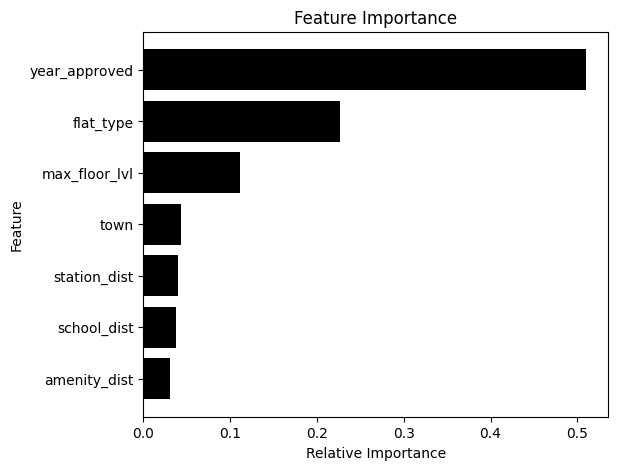

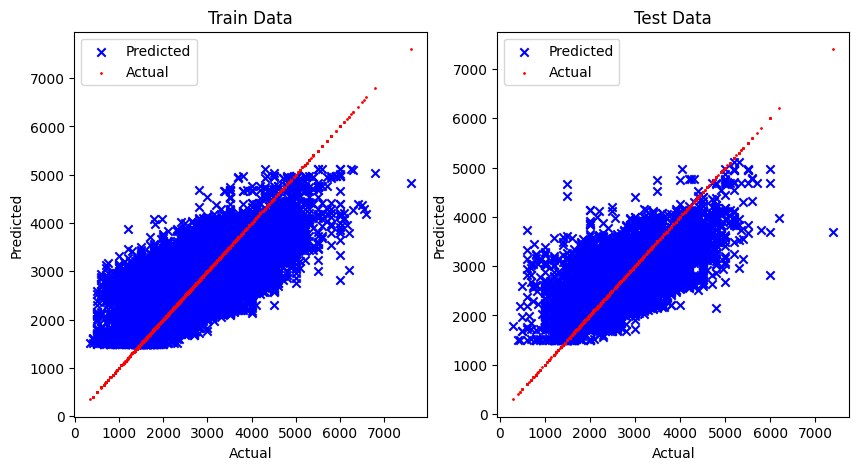

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import numpy as np

rental_train, rental_test = train_test_split(rentals, test_size=0.2, random_state=42)

X_train, X_test = rental_train.drop('monthly_rent', axis=1), rental_test.drop('monthly_rent', axis=1)
Y_train, Y_test = rental_train['monthly_rent'], rental_test['monthly_rent']

n_estimators=150
max_depth=500
max_leaf_nodes=max_depth+1

rf = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_samples=0.5, max_features=0.7, random_state = 42)
rf.fit(X_train, Y_train)

Y_train_pred_rf = rf.predict(X_train)
Y_test_pred_rf = rf.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
train_r2 = r2_score(Y_train, Y_train_pred_rf)
test_r2 = r2_score(Y_test, Y_test_pred_rf)
train_mae = mean_absolute_error(Y_train, Y_train_pred_rf)
test_mae = mean_absolute_error(Y_test, Y_test_pred_rf)
train_rmse = sqrt(mean_squared_error(Y_train, Y_train_pred_rf))
test_rmse = sqrt(mean_squared_error(Y_test, Y_test_pred_rf))

print(f'n_estimators: {n_estimators}')
print(f'Max. depth: {max_depth}')
print(f'Max. leaf nodes: {max_leaf_nodes}')
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')
print()
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print()

plt.figure(figsize=(6, 5))
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='black', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_train, Y_train, color='red', label='Actual', s = 1)
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_test, Y_test, color='red', label='Actual', s = 1)
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.show()

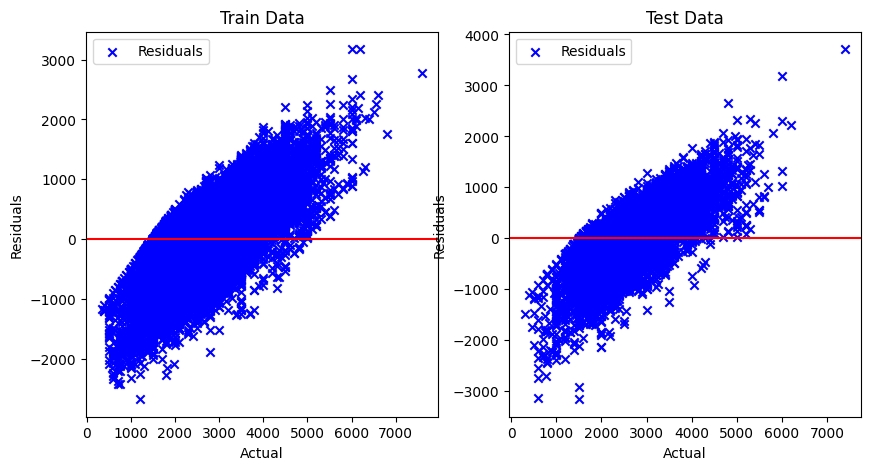

In [20]:
# plot residuals

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

residuals_train = Y_train - Y_train_pred_rf
plt.scatter(Y_train, residuals_train, color='blue', label='Residuals', marker = 'x')

plt.title('Train Data')
plt.xlabel('Actual')

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('Residuals')
plt.legend()

plt.subplot(1, 2, 2)
residuals_test = Y_test - Y_test_pred_rf
plt.scatter(Y_test, residuals_test, color='blue', label='Residuals', marker = 'x')

plt.title('Test Data')
plt.xlabel('Actual')

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('Residuals')
plt.legend()

In [21]:
test_errors = pd.DataFrame({'actual': Y_test, 'predicted': Y_test_pred_rf, 'residual': residuals_test})
test_errors['residual'] = test_errors['residual'].abs()
test_errors['percentage_error'] = (test_errors['residual'] / test_errors['actual']) * 100
test_errors['percentage_error'].mean()

16.60225125630811

In [22]:
train_errors = pd.DataFrame({'actual': Y_train, 'predicted': Y_train_pred_rf, 'residual': residuals_train})
train_errors['residual'] = train_errors['residual'].abs()
train_errors['percentage_error'] = (train_errors['residual'] / train_errors['actual']) * 100
train_errors['percentage_error'].mean()

16.09681214910707

In [23]:
# from joblib import dump

# dump(rf, '../models/rf/random_forest_rentals.joblib')

In [24]:
# do a grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [100, 200, 300],
    'max_leaf_nodes': [101, 201, 301]
}

rf = RandomForestRegressor(n_jobs=-1, random_state = 42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=100; total time=  12.1s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=100; total time=  12.5s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=100; total time=  12.9s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=150; total time=  18.6s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=150; total time=  18.7s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=150; total time=  18.7s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=200; total time=  24.4s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=200; total time=  25.5s
[CV] END max_depth=100, max_leaf_nodes=201, n_estimators=100; total time=  14.0s
[CV] END max_depth=100, max_leaf_nodes=201, n_estimators=100; total time=  13.9s
[CV] END max_depth=100, max_leaf_nodes=201, n_estimators=100; total time=  14.3s
[CV] END max_depth=100, max_leaf_nodes=101, n_estimators=200; total time=  25.0s
[CV] END max_depth=100, max_

{'max_depth': 100, 'max_leaf_nodes': 301, 'n_estimators': 200}